# Calibrating the pre-trained via Additive correction
#### Using Flux.layers to combine the two models

Combined model based on : $\quad \quad Y_{\text{final}} = f_{\text{pretrained}}(X_{\text{input}}) + f_{\text{corrected}}(X_{\text{input}}, f_{\text{pretrained}}(X_{\text{input}}))$

In [1]:
cd(@__DIR__)
using Pkg; Pkg.activate(".")
#Pkg.instantiate()

# Load the packages
using OrdinaryDiffEq, ComponentArrays, Flux, Plots, JLD2, BSON, Measures, Statistics, ProgressMeter, LinearAlgebra, Random, LaTeXStrings

Random.seed!(6) # report seed : 6

# File paths
trained_model_file = "trained_model.bson"
burgers_data_file = "burgers1d_periodic.jld2"
results_dir = "img"
mkpath(results_dir)   

# Training hyperparameters
n_epochs = 1000
batch_size = 40
learning_rate = 0.001

# Color palette
colors = palette(:bluegreenyellow)[1:6]
cur_colors = theme_palette(:auto)

nothing

  Activating new project at `~/Desktop/Deltares/Final Report Code/Model-1/combined_correction`


#### Setup

In [2]:
# Model configuration 
n_in = 1 # number of input channels (X)
n_out = 1 # number of output channels (Y)
n_hidden = 8 # number of hidden features in the model
n_filter = 3 # width of the convolutional filter

# Reuse circular padding helper
n_pad = n_filter ÷ 2
PadCircular(x) = pad_circular(x, (n_pad, n_pad, 0, 0, 0, 0))

# Reuse residual block definition
struct ResidualBlock
    f::Chain  
end

# Define how the ResidualBlock works
(m::ResidualBlock)(x) = x + m.f(x)

# Allow Flux to recognize ResidualBlock as a layer
Flux.@layer ResidualBlock

# Reuse unroll the model to get the output for the initial condition 
function unroll_pretrained(model, x0, n_steps)
    x = reshape(x0, size(x0, 1), size(x0, 2), 1) # ensure x0 is 3
    outputs = zeros(Float64, size(x0, 1), size(x0, 2), n_steps + 1)
    outputs[:, :, 1] .= x0 # store the initial condition
    # unroll the model for nstep
    for t in 1:n_steps
        x = model(x)
        outputs[:, :, t + 1] .= x
    end
    return outputs
end


unroll_pretrained (generic function with 1 method)

#### Burgers Simulation Data ####

In [3]:
# Load simulation data 
burgers_data = load(burgers_data_file)
burgers_times = burgers_data["times"]

# Extract dimensions 
n_times = length(burgers_data["solution"])
n_steps = n_times - 1
n_points = length(burgers_data["solution"][1])

# Allocate supervised learning arrays 
X = zeros(Float64, n_points, 1, n_steps)
Y = zeros(Float64, n_points, 1, n_steps)

# Define training pairs (X_t → Y_t)
for t in 1:n_steps
    X[:,:,t] .= Float64.(burgers_data["solution"][t]) # state at time t
    Y[:,:,t] .= Float64.(burgers_data["solution"][t+1]) # state at time t + 1
end

nothing

In [4]:
# Dataset split 
n_samples = size(X, 3)
n_val = 100 
n_train = 500

# Ensure the requested split is valid
if n_train + n_val > n_samples
    error("n_train + n_val must be less than or equal to the number of samples: $n_samples")
end

# Partition the dataset into training and validation sets
X_train = X[:, :, 1:n_train]
Y_train = Y[:, :, 1:n_train]

X_val = X[:, :, n_train + 1:n_train + n_val]
Y_val = Y[:, :, n_train + 1:n_train + n_val]

@show size(X_train), size(Y_train)
@show size(X_val), size(Y_val)

nothing

(size(X_train), size(Y_train)) = ((100, 1, 500), (100, 1, 500))
(size(X_val), size(Y_val)) = ((100, 1, 100), (100, 1, 100))


#### Pre-Trained Model Data 

In [5]:
# Load the pretrained surrogate model from file
loaded = BSON.load(trained_model_file)

trained_model = loaded[:trained_model] 
trained_model = f64(trained_model)
trained_params = Flux.trainable(trained_model)

println("Surrogate trained model loaded. Summary: \n$(trained_model)")
println("Number of parameters in trained model: ", sum(length, Flux.trainable(trained_model)))


Surrogate trained model loaded. Summary: 
ResidualBlock(Chain(PadCircular, Conv((3,), 1 => 8, swish), PadCircular, Conv((3,), 8 => 8, swish), PadCircular, Conv((3,), 8 => 8, swish), PadCircular, Conv((3,), 8 => 1)))
Number of parameters in trained model: 8


#### Calibration Network 

In [6]:
# Convert to Float64 precision
X_train = Float64.(X_train)
Y_train = Float64.(Y_train)

X_val = Float64.(X_val)
Y_val = Float64.(Y_val)

X = Float64.(X)

# Construct data loaders for training and validation
train_loader = Flux.DataLoader((X_train, Y_train), batchsize = min(batch_size, n_train), shuffle = true)
val_loader = Flux.DataLoader((X_val, Y_val), batchsize = min(batch_size, n_val), shuffle = false)

nothing

In [7]:
# Corrective model configuration
n_hidden_corrective = 8
n_in_corrective = 2  # two input channels: pretrained output (Y) and original input (X)
n_out_corrective = 1  # single output channel

# Corrective model architecture: small CNN with circular padding and residual-like depth
corrective_model = Chain(
    PadCircular,
    Conv((n_filter,), n_in_corrective => n_hidden_corrective, swish),
    PadCircular,
    Conv((n_filter,), n_hidden_corrective => n_hidden_corrective, swish),
    PadCircular,
    Conv((n_filter,), n_hidden_corrective => n_hidden_corrective, swish),
    PadCircular,
    Conv((n_filter,), n_hidden_corrective => n_out_corrective)
) |> f64

calibration_params = Flux.trainable(corrective_model)
println("Number of parameters in calibration model: ", sum(length, calibration_params))

Number of parameters in calibration model: 8


In [8]:
# Define a composite model that wraps a pretrained surrogate and a corrective model
struct CombinedModel
    pretrained::Any # frozen surrogate model (not trainable)
    corrective::Any # corrective model (trainable)
end

# Forward pass for CombinedModel
function (m::CombinedModel)(x)
    # Apply systematic error to input (simulate measurement/forcing error)
    x_erroneous = x .* 0.8  
    
    # Get pre-trained model output (no gradients)
    y_pretrained = m.pretrained(x_erroneous)
    
    # Combined surrogate output and erroneous input 
    combined = cat(y_pretrained, x_erroneous, dims=2)

    # Correction model output
    correction = m.corrective(combined)

    # Final corrected output 
    return y_pretrained + correction
end

# Define CombinedModel as a Flux layer
Flux.@layer CombinedModel 

# Instantiate combined model with pretrained and corrective components
combined_model = CombinedModel(trained_model, corrective_model)

# Optimizer setup
optimizer_combined = Flux.setup(Adam(learning_rate), combined_model)

# Explicitly freeze pretrained parameters (ensures only corrective is updated)
Optimisers.freeze!(optimizer_combined.pretrained)

In [9]:
# Debugging prints for CombinedModel setup 
println(Flux.state(combined_model))
println(Flux.trainable(combined_model))
println(optimizer_combined)

# Consistency checks
original_pretrained_params = deepcopy.(Flux.trainables(trained_model))
updated_pretrained_params = deepcopy(Flux.trainables(combined_model.pretrained))

all_equal = all(map(==, (Flux.trainables(combined_model.corrective)), (Flux.trainables(combined_model))))
println("All equal between corrective model and complete model params? ", all_equal)

all_equal2 = all(map(==, (Flux.trainables(combined_model.pretrained)), original_pretrained_params))
println("All params from trained model unchanged? ", all_equal2)

(pretrained = (f = (layers = ((), (σ = (), weight = [-0.03987162560224533; 0.4381643533706665; 0.2700040340423584;;; 0.3827587068080902; 0.38086748123168945; 0.23394858837127686;;; -0.06471468508243561; -0.23869934678077698; 0.2933512032032013;;; 0.17297829687595367; -0.1380167007446289; -0.017040923237800598;;; -0.3631255626678467; 0.5084885954856873; -0.034017398953437805;;; 0.36938896775245667; -0.21243304014205933; -0.4347774088382721;;; -0.40551048517227173; 0.15054002404212952; -0.32961976528167725;;; 0.15176784992218018; -0.3879319727420807; 0.3024865686893463], bias = [-0.3173278570175171, -0.37459078431129456, -0.16371990740299225, -0.08261620253324509, -0.02660205028951168, 0.2721935510635376, -0.09267693758010864, -0.11381790786981583], stride = (1,), pad = (0, 0), dilation = (1,), groups = 1), (), (σ = (), weight = [-0.10183962434530258 0.09894155710935593 -0.39404943585395813 0.19128820300102234 0.3972634971141815 0.2358887493610382 -0.006258399225771427 -0.55180823802948;

In [10]:
# Arrays to track losses across epochs
train_losses = Float64[]
val_losses = Float64[]

# Predetermine parameters to update 
corrective_params = Flux.trainable(combined_model.corrective)

# Training loop
@showprogress for epoch in 1:n_epochs

    Flux.trainmode!(combined_model)
    total_train_loss = 0.0
    num_batches = 0
    
    for (x_batch, y_batch) in train_loader
        # Compute loss and gradients for the corrective model
        loss, grads = Flux.withgradient(combined_model) do m
            y_pred = m(x_batch)
            Flux.mse(y_pred, y_batch)
        end

        # Update model parameters using optimizer
        Flux.update!(optimizer_combined, combined_model, grads[1])

        # Accumulate batch loss
        total_train_loss += loss
        num_batches += 1
    end
    
    # Average training loss for this epoch
    avg_train_loss = total_train_loss / num_batches
    push!(train_losses, avg_train_loss)
    
    # Validation phase
    Flux.testmode!(combined_model)
    
    # Compute validation loss on full validation set
    val_loss = Flux.mse(combined_model(X_val), Y_val)
    push!(val_losses, val_loss)
    
    # Show progress
    if epoch % 50 == 0
        
        all_equal2 = all(map(==, (Flux.trainables(combined_model.pretrained)), original_pretrained_params))
        println("Epoch $epoch: Train Loss = $avg_train_loss, Val Loss = $val_loss, Trained params unchanged? $all_equal2")
        
        # Confirm pretrained parameters unchanged
        for (i, (before, after)) in enumerate(zip(original_pretrained_params, Flux.trainables(combined_model.pretrained)))
            if before != after
                println("Parameter $i changed:")
                println("Before: ", before)
                println("After: ", after)
                @assert (before == after) "Pretrained parameter $i was updated!"
            end
        end
    end
end


Progress:   5%|██                                       |  ETA: 0:09:29

Epoch 50: Train Loss = 1.463664556567835e-6, Val Loss = 1.7749056906549366e-7, Trained params unchanged? true


Progress:  10%|████                                     |  ETA: 0:05:41

Epoch 100: Train Loss = 3.590309186065642e-7, Val Loss = 1.2433737808608728e-8, Trained params unchanged? true


Progress:  15%|██████▏                                  |  ETA: 0:04:21

Epoch 150: Train Loss = 3.1580635280094787e-7, Val Loss = 1.0963390764069002e-8, Trained params unchanged? true


Progress:  20%|████████▏                                |  ETA: 0:03:37

Epoch 200: Train Loss = 4.798241500866473e-7, Val Loss = 3.5003535782286415e-7, Trained params unchanged? true


Progress:  25%|██████████▎                              |  ETA: 0:03:18

Epoch 250: Train Loss = 3.8247557547542674e-7, Val Loss = 4.088012984133088e-7, Trained params unchanged? true


Progress:  30%|████████████▎                            |  ETA: 0:02:55

Epoch 300: Train Loss = 2.90580331071284e-7, Val Loss = 4.384885539266818e-8, Trained params unchanged? true


Progress:  35%|██████████████▎                          |  ETA: 0:02:35

Epoch 350: Train Loss = 3.4883511274996466e-7, Val Loss = 5.015600251854757e-8, Trained params unchanged? true


Progress:  40%|████████████████▍                        |  ETA: 0:02:17

Epoch 400: Train Loss = 3.5066464244733795e-7, Val Loss = 4.7403512524476115e-7, Trained params unchanged? true


Progress:  45%|██████████████████▍                      |  ETA: 0:02:01

Epoch 450: Train Loss = 4.305148441034564e-7, Val Loss = 1.8666756307466219e-7, Trained params unchanged? true


Progress:  50%|████████████████████▌                    |  ETA: 0:01:47

Epoch 500: Train Loss = 1.0304094010423942e-6, Val Loss = 5.494251028264451e-7, Trained params unchanged? true


Progress:  55%|██████████████████████▌                  |  ETA: 0:01:35

Epoch 550: Train Loss = 2.01294355830714e-7, Val Loss = 4.288396527506102e-7, Trained params unchanged? true


Progress:  60%|████████████████████████▌                |  ETA: 0:01:23

Epoch 600: Train Loss = 1.905697472451165e-7, Val Loss = 4.156529001231763e-8, Trained params unchanged? true


Progress:  65%|██████████████████████████▋              |  ETA: 0:01:11

Epoch 650: Train Loss = 3.2744608148497973e-7, Val Loss = 6.32183657243526e-8, Trained params unchanged? true


Progress:  70%|████████████████████████████▋            |  ETA: 0:01:00

Epoch 700: Train Loss = 1.8875932310761883e-7, Val Loss = 3.155808299096211e-8, Trained params unchanged? true


Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:50

Epoch 750: Train Loss = 1.986324341818038e-7, Val Loss = 2.656061699707191e-7, Trained params unchanged? true


Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:39

Epoch 800: Train Loss = 2.818824159177799e-7, Val Loss = 3.2608263789990365e-8, Trained params unchanged? true


Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:29

Epoch 850: Train Loss = 1.7582191211154238e-7, Val Loss = 2.9530274534977284e-7, Trained params unchanged? true


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:19

Epoch 900: Train Loss = 2.3860267464956304e-7, Val Loss = 3.619769930143456e-8, Trained params unchanged? true


Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:10

Epoch 950: Train Loss = 2.0875565166844375e-7, Val Loss = 8.533356094971795e-8, Trained params unchanged? true


Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00

Epoch 1000: Train Loss = 2.872237389763733e-7, Val Loss = 1.1510873739372312e-8, Trained params unchanged? true


Progress: 100%|█████████████████████████████████████████| Time: 0:03:08


In [11]:
# Check final status of pretrained parameters is unchanged
for (i, (before, after)) in enumerate(zip(original_pretrained_params, Flux.trainables(combined_model.pretrained)))
    if before != after
        println("Parameter $i changed:")
        println("Before: ", before)
        println("After: ", after)
        @assert (before == after) "Pretrained parameter $i was updated!"
    end
end

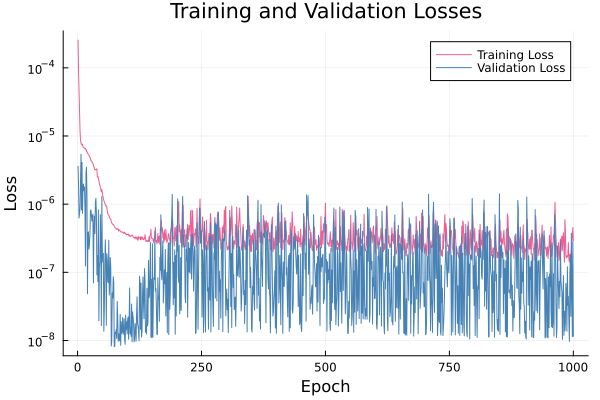

In [12]:
# Plot training and validation loss curves
p = plot(train_losses,label = "Training Loss",xlabel = "Epoch",ylabel = "Loss",title = "Training and Validation Losses", yscale = :log10, color=cur_colors[7])
plot!(val_losses,label = "Validation Loss",yscale = :log10,color=:steelblue)
savefig(joinpath(results_dir, "combined_correction_loss.png"))
display(p)

#### Correction Testing

In [13]:
# Roll out the corrected surrogate model over multiple time steps
function unroll_corrected(combined_model, x0, n_steps)
    # Initial condition: x0 reshape to (n_points, 1, 1)
    x = reshape(x0, size(x0, 1), 1, 1)

    # Allocate output array to store the full trajectory (initial + n_steps)
    outputs = zeros(eltype(x0), size(x0, 1), 1, n_steps + 1)
    outputs[:, :, 1] .= x0   # store initial condition at t = 0

    # Time-stepping loop
    for t in 1:n_steps
        # Final corrected output 
        y_final = combined_model(x)
        outputs[:,:,t+1] .= reshape(y_final, size(y_final,1), 1)
              
        # Use corrected output as input for next iteration
        x = y_final                      
    end

    return outputs
end


unroll_corrected (generic function with 1 method)

In [14]:
# Roll out only the pretrained surrogate model over multiple time steps
function unroll_pretrained_only(combined_model, x0, n_steps)
    # Initial condition: x0 reshape to (n_points, 1, 1)
    x = reshape(x0, size(x0,1), 1, 1)

    # Allocate output array to store the full trajectory (initial + n_steps)
    outputs = zeros(eltype(x0), size(x0,1), 1, n_steps+1)
    outputs[:, :, 1] .= x0

    # Time-stepping loop
    for t in 1:n_steps
        # Forward pass through pretrained surrogate only (no corrective model)
        y_pretrained = combined_model.pretrained(x)  
        outputs[:, :, t + 1] .= reshape(y_pretrained, size(y_pretrained, 1), 1)
            
        # Use corrected output as input for next iteration
        x = y_pretrained  
    end
    return outputs
end

unroll_pretrained_only (generic function with 1 method)

In [15]:
# Ensure consistency in rollout length
n_steps = length(burgers_times) - 1   
output_times = burgers_times[1:n_steps+1]
output_x = burgers_data["grid"]

# Initial condition (first snapshot from dataset)
x0 = X[:,:,1]

# Ground-truth trajectory from dataset
Y_true = zeros(Float64, n_points, 1, n_steps+1)
for t in 1:(n_steps+1)
    Y_true[:,1,t] .= burgers_data["solution"][t]
end

# Roll out pretrained surrogate model
Y_pretrained = unroll_pretrained(trained_model, x0, n_steps)

# Roll out corrected surrogate model
Y_corrected  = unroll_corrected(combined_model, x0, n_steps)

# Roll out pretrained surrogate model only from combined model
Y_pretrained_only = unroll_pretrained_only(combined_model, x0, n_steps)

nothing


In [16]:
# Calculate accuracy between specific time steps for 3D arrays
function calculate_accuracy(Y_pred, Y_true; tolerance=0.025, initial_step=1, final_step=size(Y_true, 3))
    # Validate input parameters
    if initial_step < 1 || final_step > size(Y_true, 3) || initial_step > final_step
        error("Invalid time step range: initial_step=$initial_step, final_step=$final_step, data length=$(size(Y_true, 3))")
    end
    
    # Extract the specified time step range from the third dimension
    Y_pred_range = Y_pred[:, :, initial_step:final_step]
    Y_true_range = Y_true[:, :, initial_step:final_step]
    
    # Calculate accuracy for the specified range
    correct_predictions = sum((abs.(Y_pred_range .- Y_true_range)) .< tolerance)
    accuracy = (correct_predictions / length(Y_true_range)) * 100
    
    return accuracy
end

calculate_accuracy (generic function with 1 method)

In [17]:
# Calculate accuracy for both pretrained and corrected models for complete trajectory
accuracy_pretrained_full = calculate_accuracy(Y_pretrained, Y_true)
accuracy_corrected_full = calculate_accuracy(Y_corrected, Y_true)

println("Pretrained Model Accuracy: $(round(accuracy_pretrained_full, digits=2))%")
println("Corrected Model Accuracy: $(round(accuracy_corrected_full, digits=2))%")
println("Accuracy Improvement in Full model: $(round((accuracy_corrected_full - accuracy_pretrained_full), digits=2))%")

Pretrained Model Accuracy: 69.32%
Corrected Model Accuracy: 90.2%
Accuracy Improvement in Full model: 20.88%


In [18]:
# Calculate accuracy for both pretrained and corrected models at specific early time range
accuracy_pretrained_range = calculate_accuracy(Y_pretrained, Y_true, initial_step=50, final_step=150)
accuracy_corrected_range = calculate_accuracy(Y_corrected, Y_true, initial_step=50, final_step=150)

println("\nTime Steps 50-150 Results:")
println("Pretrained Model Accuracy: $(round(accuracy_pretrained_range, digits=2))%")
println("Corrected Model Accuracy: $(round(accuracy_corrected_range, digits=2))%")
println("Accuracy Improvement in Range: $(round((accuracy_corrected_range - accuracy_pretrained_range), digits=2))%")

# Calculate accuracy for both pretrained and corrected models at specific late time range
accuracy_pretrained_range2 = calculate_accuracy(Y_pretrained, Y_true, initial_step=250)
accuracy_corrected_range2 = calculate_accuracy(Y_corrected, Y_true, initial_step=250)

println("\nTime Steps 250-End Results:")
println("Pretrained Model Accuracy: $(round(accuracy_pretrained_range2, digits=2))%")
println("Corrected Model Accuracy: $(round(accuracy_corrected_range2, digits=2))%")
println("Accuracy Improvement in Range: $(round((accuracy_corrected_range2 - accuracy_pretrained_range2), digits=2))%")



Time Steps 50-150 Results:
Pretrained Model Accuracy: 91.7%
Corrected Model Accuracy: 93.55%
Accuracy Improvement in Range: 1.85%

Time Steps 250-End Results:
Pretrained Model Accuracy: 63.32%
Corrected Model Accuracy: 89.42%
Accuracy Improvement in Range: 26.11%


In [19]:
function field_metrics(Y_pred, Y_true; eps=1e-8)
    # Difference field
    difference = Y_pred .- Y_true

    # Per-time RMSE and Linf
    rmse_t = sqrt.(mean(abs2, difference; dims=(1,2)))
    linf_t = maximum(abs.(difference); dims=(1,2))

    # Global RMSE and normalized RMSE
    rmse_global = sqrt(mean(abs2.(difference)))
    nrmse_global = rmse_global / (std(Y_true) + eps)

    # Percent within relative tolerance 
    rel_err = abs.(difference) ./ (abs.(Y_true) .+ eps)
    within_5pct = 100 * sum(rel_err .< 0.05) / length(Y_true)

    #C oefficient of determination
    ss_res = sum(abs2.(difference))
    ss_tot = sum(abs2.(Y_true .- mean(Y_true)))
    r2_score = 1.0 - ss_res / (ss_tot + eps)

    return Dict(
    "rmse_t" => vec(rmse_t),
    "linf_t" => vec(linf_t),
    "rmse_global" => rmse_global,
    "nrmse_global" => nrmse_global,
    "pct_within_5pct" => within_5pct, 
    "r2_score" => r2_score
    )
end


field_metrics (generic function with 1 method)

Pre-Trained Results: Global RMSE: 0.03441119383280477 | Normalized RMSE: 0.3087325688926965 
                                   | Percentage within tolerance: 84.27272727272727 | R2 Score: 0.9046832315870033
Corrected Results: Global RMSE: 0.016956472489585348 | Normalized RMSE: 0.1521311738413851 
                                   | Percentage within tolerance: 99.26573426573427 | R2 Score: 0.976855870582866


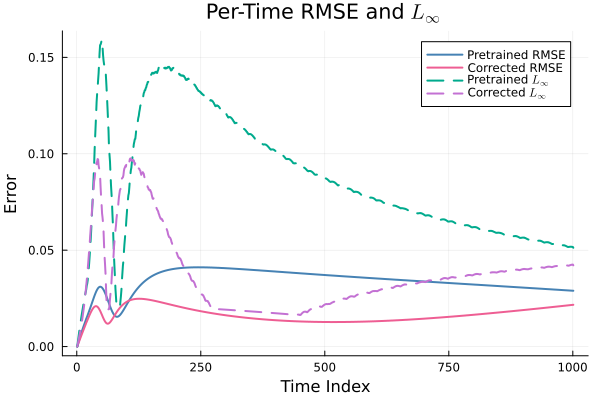

In [20]:
pretrained_metrics = field_metrics(Y_pretrained, Y_true)
corrected_metrics = field_metrics(Y_corrected, Y_true)

println("Pre-Trained Results: Global RMSE: $(pretrained_metrics["rmse_global"]) | Normalized RMSE: $(pretrained_metrics["nrmse_global"]) \n",
        "                                   | Percentage within tolerance: $(pretrained_metrics["pct_within_5pct"]) | R2 Score: $(pretrained_metrics["r2_score"])")
println("Corrected Results: Global RMSE: $(corrected_metrics["rmse_global"]) | Normalized RMSE: $(corrected_metrics["nrmse_global"]) \n",
        "                                   | Percentage within tolerance: $(corrected_metrics["pct_within_5pct"]) | R2 Score: $(corrected_metrics["r2_score"])")

p = plot(pretrained_metrics["rmse_t"], title=L"Per-Time RMSE and $L_{\infty}$", xlabel="Time Index", ylabel="Error", legend=true, linewidth=2, color=:steelblue, label="Pretrained RMSE")
plot!(corrected_metrics["rmse_t"], linewidth=2, color=cur_colors[7], label="Corrected RMSE", linestyle=:solid)
plot!(pretrained_metrics["linf_t"], linewidth=2, color=cur_colors[9], label=L"Pretrained $L_{\infty}$", linestyle=:dash)
plot!(corrected_metrics["linf_t"], linewidth=2, color=cur_colors[4], label=L"Corrected $L_{\infty}$", linestyle=:dash)

savefig(joinpath(results_dir, "combined_correction_pertimeRMSE.png"))
display(p)

#### Visual Comparison

In [21]:
function plot_frame(n; save=nothing)
    # Plot a single frame comparing true, pretrained, and corrected solutions
    p = plot(output_x, Y_true[:,1,n], label="Target u(t=$(round(output_times[n], digits=2)))", xlabel="x", ylabel="u", 
         ylim=(0,2), lw=1.5)
    plot!(output_x, Y_pretrained[:,1,n], label="Pretrained u", linestyle=:dash, lw=1.5)
    plot!(output_x, Y_corrected[:,1,n], label="Corrected u", linestyle=:dot, lw=1.5)
    plot!(size=(800,400), title="1D Burgers Equation: True vs Pretrained vs Corrected")

    if save !== nothing
        savefig(save)
    end
    display(p)
end

plot_frame (generic function with 1 method)

In [22]:
function plot_point_time_series(point_index; save=nothing)
    # Plot time series at a specific spatial point comparing true, pretrained, and corrected solutions
    p = plot(output_times, Y_true[point_index, 1, :], label="Target u(x=$(round(output_x[point_index], digits=2)), t)", xlabel="Time", ylabel="u", lw=1.5)
    plot!(output_times, Y_pretrained[point_index, 1, :], label="Pretrained u", linestyle=:dash, lw=1.5)
    plot!(output_times, Y_corrected[point_index, 1, :], label="Corrected u", linestyle=:dot, lw=1.5)
    plot!(size=(800,400), title="Time Series at x = $(round(output_x[point_index], digits=2))")
    
    if save !== nothing
        savefig(save)
    end
    return p
end

plot_point_time_series (generic function with 1 method)

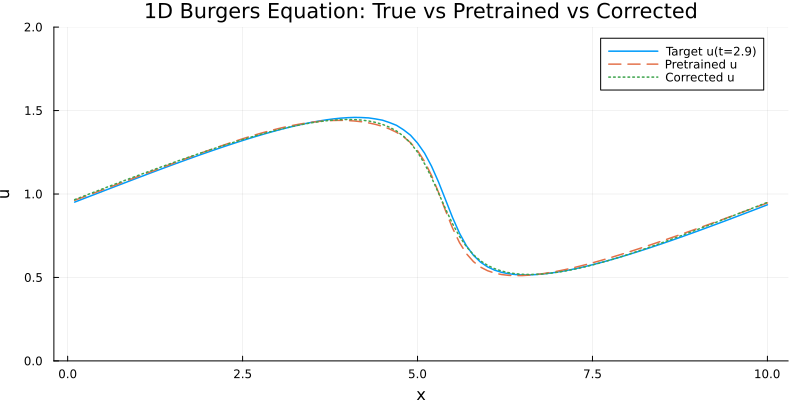

In [23]:
plot_frame(30, save=joinpath(results_dir, "combined_correction_frame_30.png"))

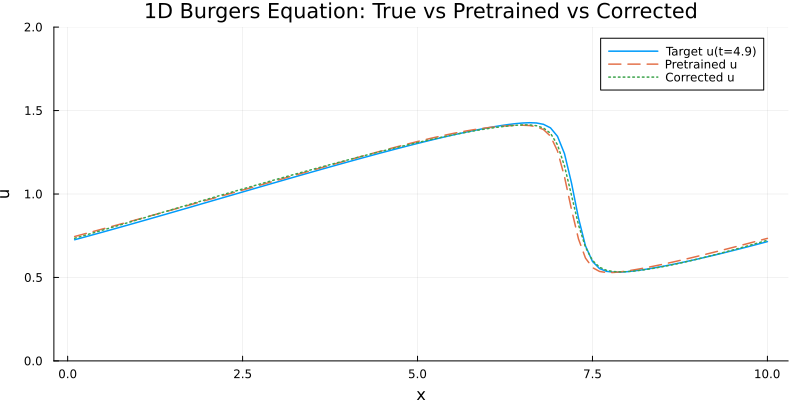

In [24]:
plot_frame(50, save=joinpath(results_dir, "combined_correction_frame_50.png"))

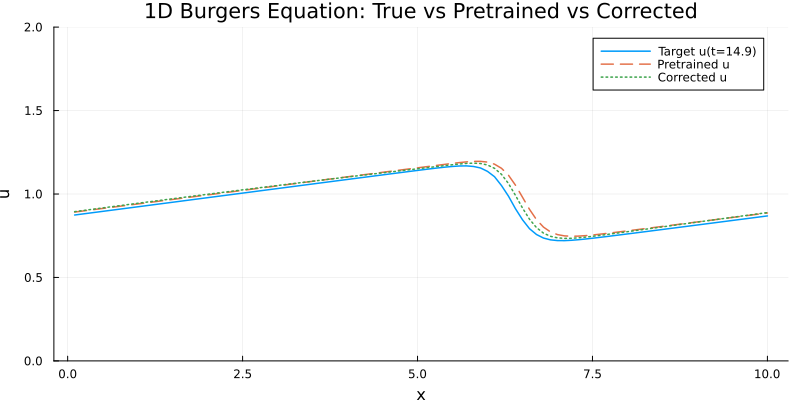

In [25]:
plot_frame(150, save=joinpath(results_dir, "combined_correction_frame_150.png"))

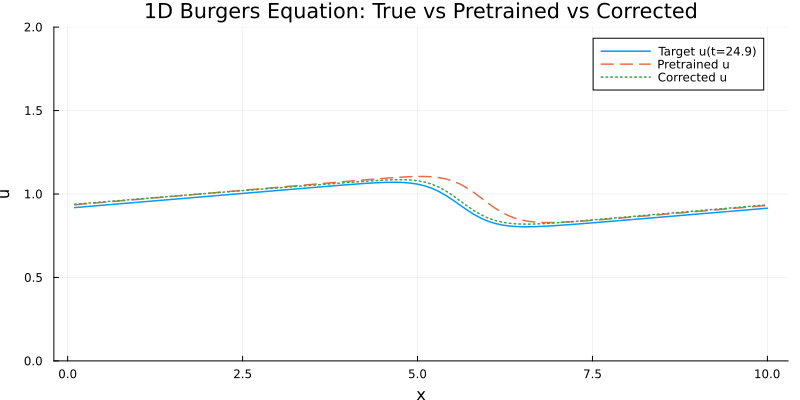

In [26]:
plot_frame(250, save=joinpath(results_dir, "combined_correction_frame_250.png"))

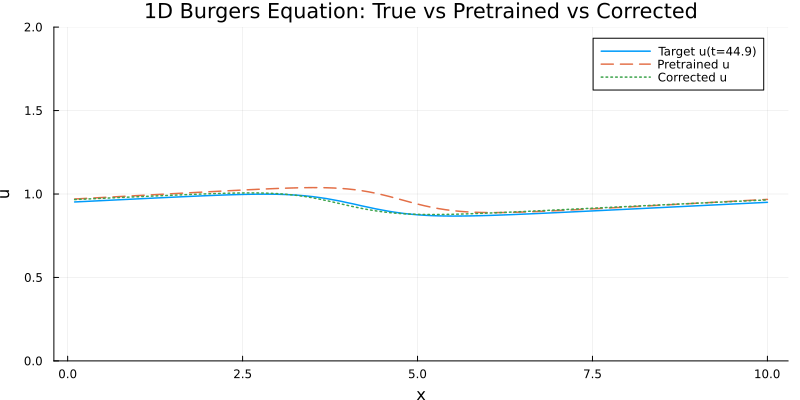

In [27]:
plot_frame(450, save=joinpath(results_dir, "combined_correction_frame_450.png"))

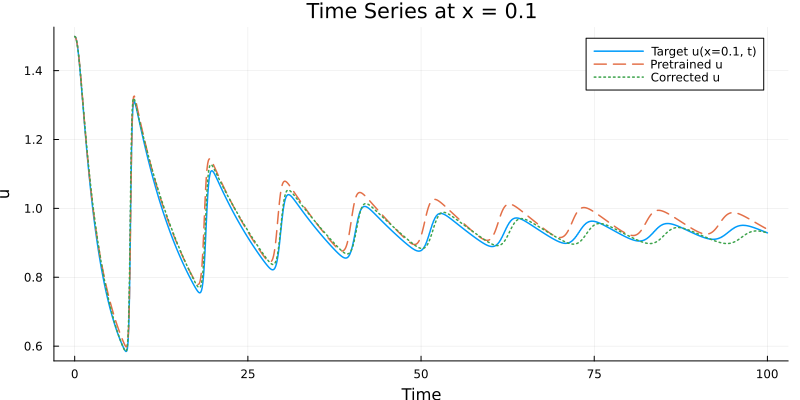

In [28]:
plot_point_time_series(1, save=joinpath(results_dir, "combined_time_series_1.png"))

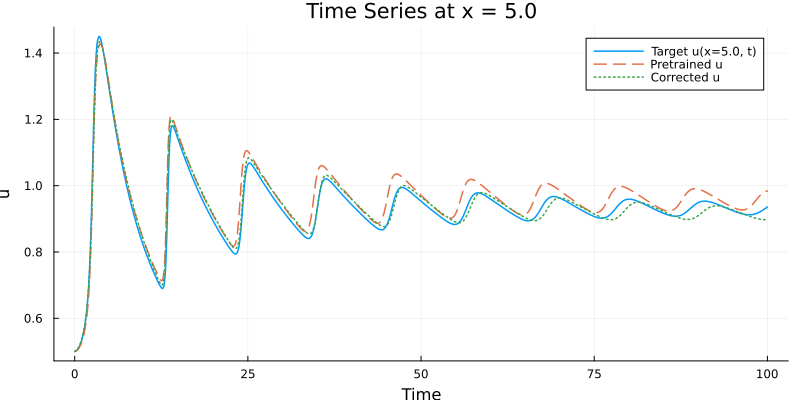

In [29]:
plot_point_time_series(50, save=joinpath(results_dir, "combined_time_series_50.png"))

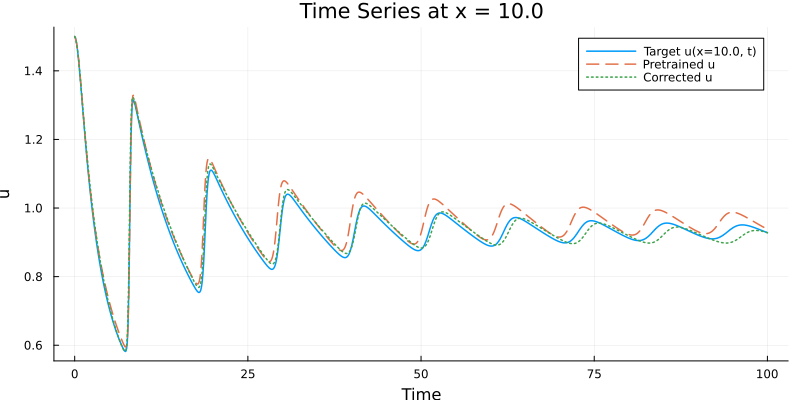

In [30]:
plot_point_time_series(n_points, save=joinpath(results_dir, "combined_time_series_$n_points.png"))

┌ Info: Saved animation to /Users/sara/Desktop/Deltares/Final Report Code/Model-1/combined_correction/img/combined_correction_gif.gif
└ @ Plots /Users/sara/.julia/packages/Plots/8ZnR3/src/animation.jl:156


 29.955593 seconds (15.97 M allocations: 630.130 MiB, 1.62% gc time, 1.41% compilation time: 13% of which was recompilation)


Plots.AnimatedGif("/Users/sara/Desktop/Deltares/Final Report Code/Model-1/combined_correction/img/combined_correction_gif.gif")
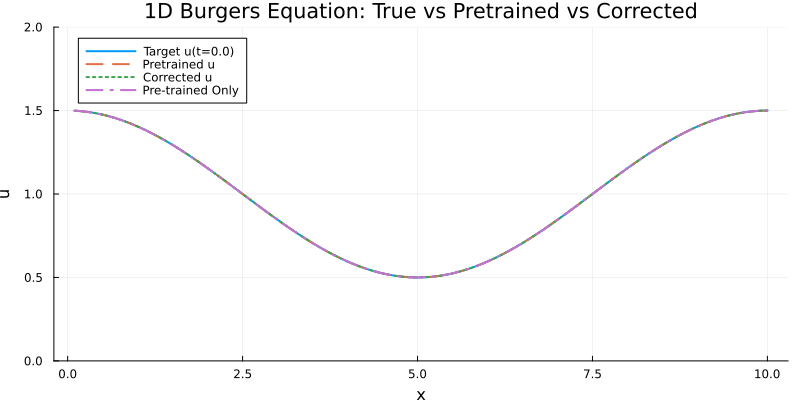

In [31]:
@time begin
    anim = @animate for i in 1:length(output_times)
        p = plot(output_x, Y_true[:,1,i], label="Target u(t=$(round(output_times[i], digits=2)))", xlabel="x", ylabel="u", ylim=(0,2), lw=2)
        plot!(output_x, Y_pretrained[:,1,i], label="Pretrained u", linestyle=:dash, lw=2)
        plot!(output_x, Y_corrected[:,1,i], label="Corrected u", linestyle=:dot, lw=2)
        plot!(output_x, Y_pretrained_only[:,1,i], label="Pre-trained Only", linestyle=:dashdot, lw=2)
        plot!(p, size=(800,400), title="1D Burgers Equation: True vs Pretrained vs Corrected")
    end
    gif(anim, joinpath(results_dir, "combined_correction_gif.gif"), fps=15)
end

#### Save Correction Model

In [32]:
BSON.@save "combined_correction.bson" model=combined_model